<a href="https://colab.research.google.com/github/douglasmmachado/MedicineConsumption/blob/main/notebooks/causal_method/unified_approach/5_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5 - Forecasting and prediction



---



---



In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import math as m

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,  mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV


df_agg_clusters_url = "https://raw.githubusercontent.com/douglasmmachado/MedicineConsumption/main/datasets/unified_approach/clustered/df_clustered.csv"
df_url = "https://raw.githubusercontent.com/douglasmmachado/ExploratoryDataAnalysis/main/datasets/unified_approach/df_ma.csv"
df_clustered_pca_url = "https://raw.githubusercontent.com/douglasmmachado/MedicineConsumption/main/datasets/unified_approach/clustered/df_clustered_pca.csv"

df = pd.read_csv(df_url)
df_agg_clusters = pd.read_csv(df_agg_clusters_url)
df_clustered_pca = pd.read_csv(df_clustered_pca_url)


# Convert numerical columns to string
for i, curr_df in enumerate([df, df_agg_clusters]):
    numerical_columns = ['HOSPI_CODE_UCD']
    curr_df[numerical_columns] = curr_df[numerical_columns].astype('string')


medicines = ['3400892088310','3400892075761','3400892203645',
             '3400892065366','3400892052120','3400891996128',
             '3400893826706','3400893736135','3400893875490',
             '3400890837149','3400891235203','3400891225037',
             '3400891191226','3400892729589','3400892745848',
             '3400892697789','3400892761527','3400893022634',
             '3400892761695','3400892669236','3400892508566']

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 42 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DATE            4072 non-null   object 
 1   HOSPI_CODE_UCD  4072 non-null   string 
 2   LIT_HC          4072 non-null   float64
 3   LIT_HP          4072 non-null   float64
 4   N_ETB           4072 non-null   float64
 5   N_UFS           4072 non-null   float64
 6   PN_MEDICAL      4072 non-null   float64
 7   POPULATION      4072 non-null   float64
 8   P_MEDICAL       4072 non-null   float64
 9   QUANTITY        4072 non-null   float64
 10  QUANTITY_MA     4072 non-null   float64
 11  RESID           4072 non-null   float64
 12  SEASONAL        4072 non-null   float64
 13  SEJ_HAD         4072 non-null   float64
 14  SEJ_MCO         4072 non-null   float64
 15  SEJ_PSY         4072 non-null   float64
 16  SEJ_SLD         4072 non-null   float64
 17  SEJ_SSR         4072 non-null   f

In [27]:
df_agg_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3867 entries, 0 to 3866
Data columns (total 43 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DATE            3867 non-null   object 
 1   HOSPI_CODE_UCD  3867 non-null   string 
 2   LIT_HC          3867 non-null   float64
 3   LIT_HP          3867 non-null   float64
 4   N_ETB           3867 non-null   float64
 5   N_UFS           3867 non-null   float64
 6   PN_MEDICAL      3867 non-null   float64
 7   POPULATION      3867 non-null   float64
 8   P_MEDICAL       3867 non-null   float64
 9   QUANTITY        3867 non-null   float64
 10  QUANTITY_MA     3867 non-null   float64
 11  RESID           3867 non-null   float64
 12  SEASONAL        3867 non-null   float64
 13  SEJ_HAD         3867 non-null   float64
 14  SEJ_MCO         3867 non-null   float64
 15  SEJ_PSY         3867 non-null   float64
 16  SEJ_SLD         3867 non-null   float64
 17  SEJ_SSR         3867 non-null   f

In [28]:
df_agg_clusters = df_agg_clusters[df_agg_clusters['QUANTITY'] > 0]
df_agg_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3867 entries, 0 to 3866
Data columns (total 43 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DATE            3867 non-null   object 
 1   HOSPI_CODE_UCD  3867 non-null   string 
 2   LIT_HC          3867 non-null   float64
 3   LIT_HP          3867 non-null   float64
 4   N_ETB           3867 non-null   float64
 5   N_UFS           3867 non-null   float64
 6   PN_MEDICAL      3867 non-null   float64
 7   POPULATION      3867 non-null   float64
 8   P_MEDICAL       3867 non-null   float64
 9   QUANTITY        3867 non-null   float64
 10  QUANTITY_MA     3867 non-null   float64
 11  RESID           3867 non-null   float64
 12  SEASONAL        3867 non-null   float64
 13  SEJ_HAD         3867 non-null   float64
 14  SEJ_MCO         3867 non-null   float64
 15  SEJ_PSY         3867 non-null   float64
 16  SEJ_SLD         3867 non-null   float64
 17  SEJ_SSR         3867 non-null   f

In [29]:
df = df[(df['QUANTITY'] > 0)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4072 entries, 0 to 4071
Data columns (total 42 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DATE            4072 non-null   object 
 1   HOSPI_CODE_UCD  4072 non-null   string 
 2   LIT_HC          4072 non-null   float64
 3   LIT_HP          4072 non-null   float64
 4   N_ETB           4072 non-null   float64
 5   N_UFS           4072 non-null   float64
 6   PN_MEDICAL      4072 non-null   float64
 7   POPULATION      4072 non-null   float64
 8   P_MEDICAL       4072 non-null   float64
 9   QUANTITY        4072 non-null   float64
 10  QUANTITY_MA     4072 non-null   float64
 11  RESID           4072 non-null   float64
 12  SEASONAL        4072 non-null   float64
 13  SEJ_HAD         4072 non-null   float64
 14  SEJ_MCO         4072 non-null   float64
 15  SEJ_PSY         4072 non-null   float64
 16  SEJ_SLD         4072 non-null   float64
 17  SEJ_SSR         4072 non-null   f

In [30]:
df_clustered_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3867 entries, 0 to 3866
Data columns (total 43 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DATE            3867 non-null   object 
 1   HOSPI_CODE_UCD  3867 non-null   int64  
 2   LIT_HC          3867 non-null   float64
 3   LIT_HP          3867 non-null   float64
 4   N_ETB           3867 non-null   float64
 5   N_UFS           3867 non-null   float64
 6   PN_MEDICAL      3867 non-null   float64
 7   POPULATION      3867 non-null   float64
 8   P_MEDICAL       3867 non-null   float64
 9   QUANTITY        3867 non-null   float64
 10  QUANTITY_MA     3867 non-null   float64
 11  RESID           3867 non-null   float64
 12  SEASONAL        3867 non-null   float64
 13  SEJ_HAD         3867 non-null   float64
 14  SEJ_MCO         3867 non-null   float64
 15  SEJ_PSY         3867 non-null   float64
 16  SEJ_SLD         3867 non-null   float64
 17  SEJ_SSR         3867 non-null   f

## 5.1 - New database composition based on clusters

## 5.2 - Building forecasting models based on clusters

In [31]:
def plot_pred(y_pred, y_test, medicine):
    plt.subplot(1, 2, 2)

    # Scatter plot for y_pred
    plt.scatter(np.arange(len(y_pred)), y_pred, marker='o', label='y_pred', color='blue')

    # Scatter plot for y_test
    plt.scatter(np.arange(len(y_test)), y_test, marker='x', label='y_test', color='red')

    # Set axes labels and title
    plt.xlabel('Test samples')
    plt.ylabel('Quantity')
    plt.title(f'y_pred and y_test for medicine: {medicine}')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

In [32]:
def plot_mape(y_pred, y_test, medicine, epsilon=0.001):
    mape_array = np.abs(y_test - y_pred) / np.maximum(epsilon, np.abs(y_test))

    # Create a stem plot for MAPE
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.stem(np.arange(len(y_pred)), mape_array, markerfmt='bo', linefmt='b-', basefmt='r-', label='MAPE')
    plt.xlabel('Test samples')
    plt.ylabel('MAPE')
    plt.title(f'MAPE for medicine: {medicine}')
    plt.legend()

In [33]:
def test_1_baseline(df, medicine, df_scores):
  print()
  print(100*'-')
  print('Medicine:' + str(medicine))

  X = df[df['HOSPI_CODE_UCD'] == medicine].drop(['ID_SITE_RATTACHE', 'QUANTITY', 'HOSPI_CODE_UCD',
                                                 'DATE', 'QUANTITY_MA', 'TREND', 'SEASONAL', 'RESID'], axis=1).values

  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  y = df[df['HOSPI_CODE_UCD'] == medicine]['QUANTITY'].values

  X_scaled, y = shuffle(X_scaled, y, random_state=42)

  if m.ceil(len(X_scaled) * 0.1) == 1:
    print('Dataset too small')
    test_size = 2
  else:
    test_size = 0.1

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                      test_size = test_size,
                                                      random_state = 42)
  print(f'Size of data set: {len(X)}')
  print(f'Size of training set: {len(X_train)}')
  print(f'Size of test set: {len(X_test)}')

  # Define the parameter distributions for RandomizedSearchCV
  param_grid = {
      'max_depth': np.arange(2, 8, 1),
      'n_estimators': np.arange(2, max(int(m.ceil(len(X_train)*0.1)),3), 1),
      'max_features': ['sqrt']
  }
  depth_len = param_grid['max_depth'].size
  estimators_len = param_grid['n_estimators'].size

  print(f'Size of grid search: {depth_len * estimators_len}')

  # Create the RandomizedSearchCV object
  grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                             param_grid=param_grid,
                             scoring = 'neg_mean_absolute_percentage_error',
                             cv = 5,
                             n_jobs = -1)

  ''' >3 : the fold and candidate parameter indexes
      are also displayed together with the starting time of the computation.
  '''
  # Fit the RandomizedSearchCV object to the data
  grid_search.fit(X_train, y_train)

  # Get the best estimator
  best_estimator = grid_search.best_estimator_

  # Make predictions using the best estimator
  y_pred = best_estimator.predict(X_test)

  # Calculate R^2 score
  r2 = r2_score(y_test, y_pred)

  # Calculate MAE
  mae = mean_absolute_error(y_test, y_pred)

  # Calculate MAPE
  mape = mean_absolute_percentage_error(y_test, y_pred)

  # Calculate RMSE
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))

  # Print the best parameters, best score, and evaluation metrics
  print('Best Parameters: ', grid_search.best_params_)
  print('Training Score (MAPE): ', round(grid_search.best_score_, 3))
  print(10*'-' + 'Test scores' + 10*'-')
  print('R^2 Score:', round(r2, 3))
  print('MAE:', round(mae, 3))
  print('MAPE:', round(mape, 3))
  print('RMSE:', round(rmse, 3))
  print()


  # Create the new row as a DataFrame
  new_row = pd.DataFrame({'HOSPI_CODE_UCD': ['CODE_UCD_'+str(medicine)],
                          'R2': [r2],
                          'RMSE': [rmse],
                          'MAE': [mae],
                          'MAPE': [mape]})

  # Append the new row to the DataFrame
  df_scores = pd.concat([df_scores, new_row], ignore_index=True)

  plot_mape(y_pred, y_test, medicine)
  print()

  # plot pred x test
  plot_pred(y_pred, y_test, medicine)
  print()




  # Return the updated DataFrame
  return df_scores



----------------------------------------------------------------------------------------------------
Medicine:3400892088310
Size of data set: 171
Size of training set: 153
Size of test set: 18
Size of grid search: 84
Best Parameters:  {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 2}
Training Score (MAPE):  -2.142
----------Test scores----------
R^2 Score: 0.765
MAE: 619.138
MAPE: 0.202
RMSE: 987.546




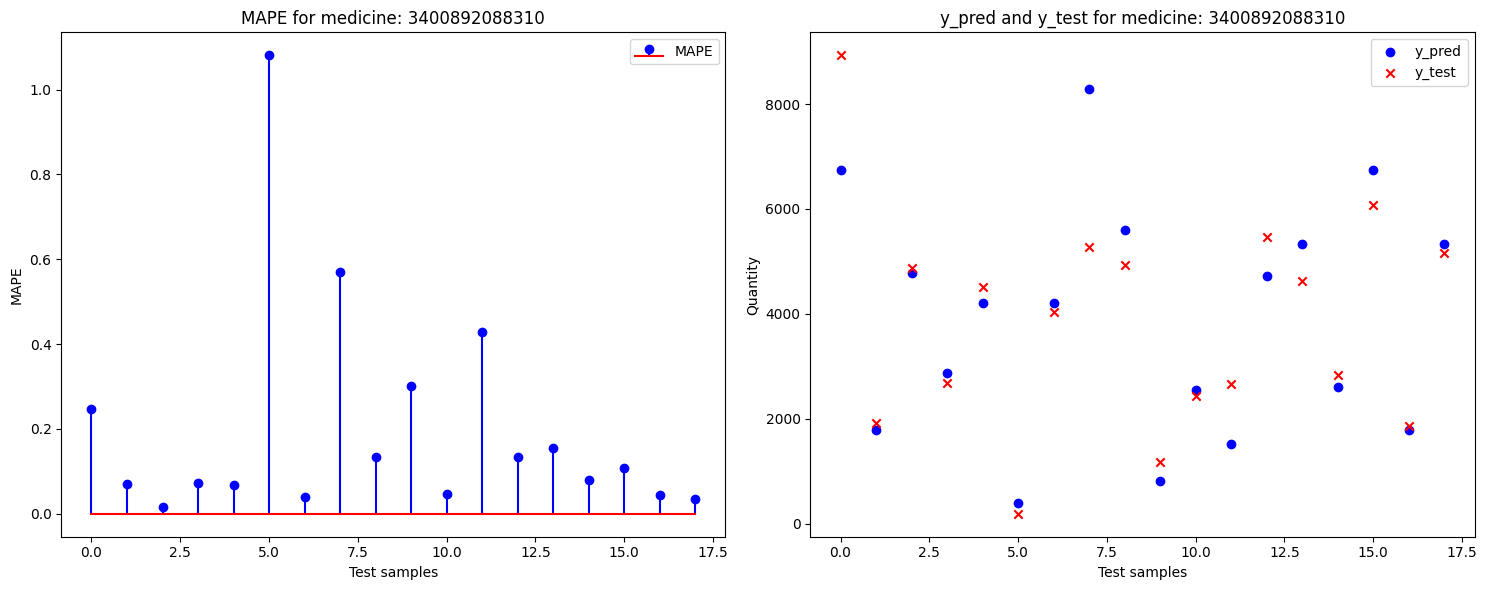



----------------------------------------------------------------------------------------------------
Medicine:3400892075761
Size of data set: 204
Size of training set: 183
Size of test set: 21
Size of grid search: 102
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 2}
Training Score (MAPE):  -0.861
----------Test scores----------
R^2 Score: 0.752
MAE: 662.112
MAPE: 0.312
RMSE: 1390.429




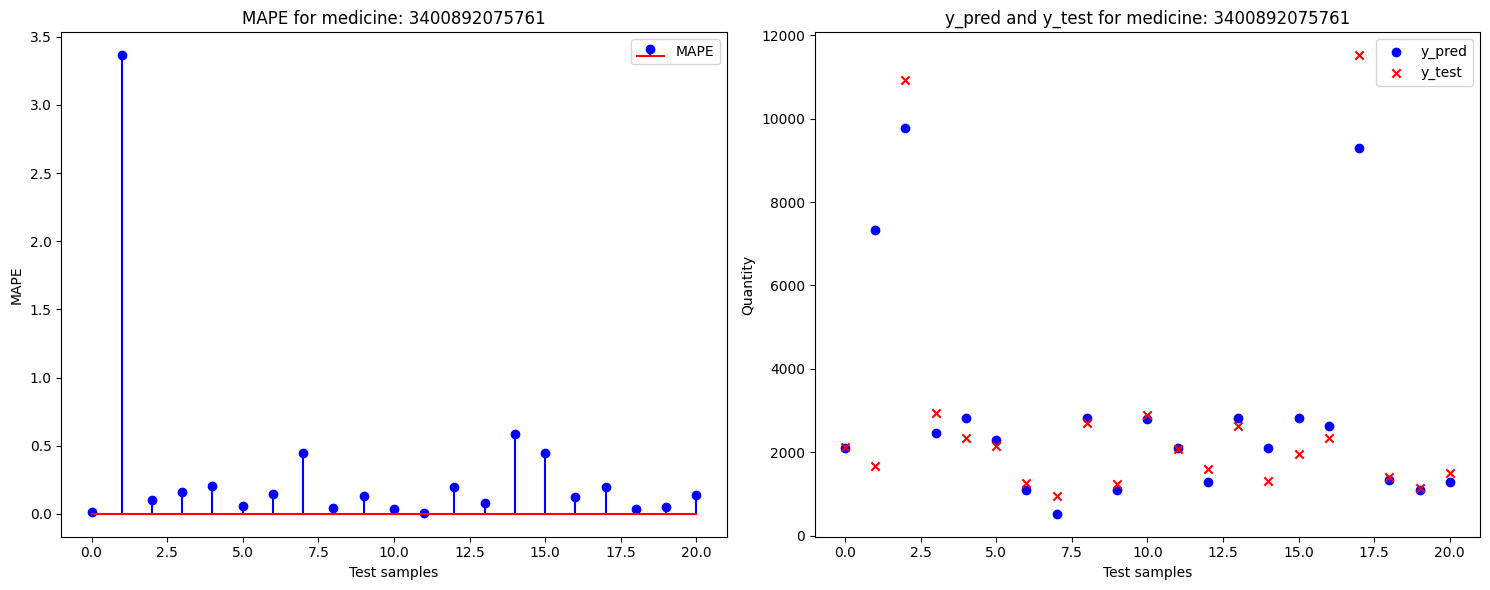



----------------------------------------------------------------------------------------------------
Medicine:3400892203645
Size of data set: 200
Size of training set: 180
Size of test set: 20
Size of grid search: 96
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 2}
Training Score (MAPE):  -0.821
----------Test scores----------
R^2 Score: 0.916
MAE: 873.989
MAPE: 1.334
RMSE: 1087.714




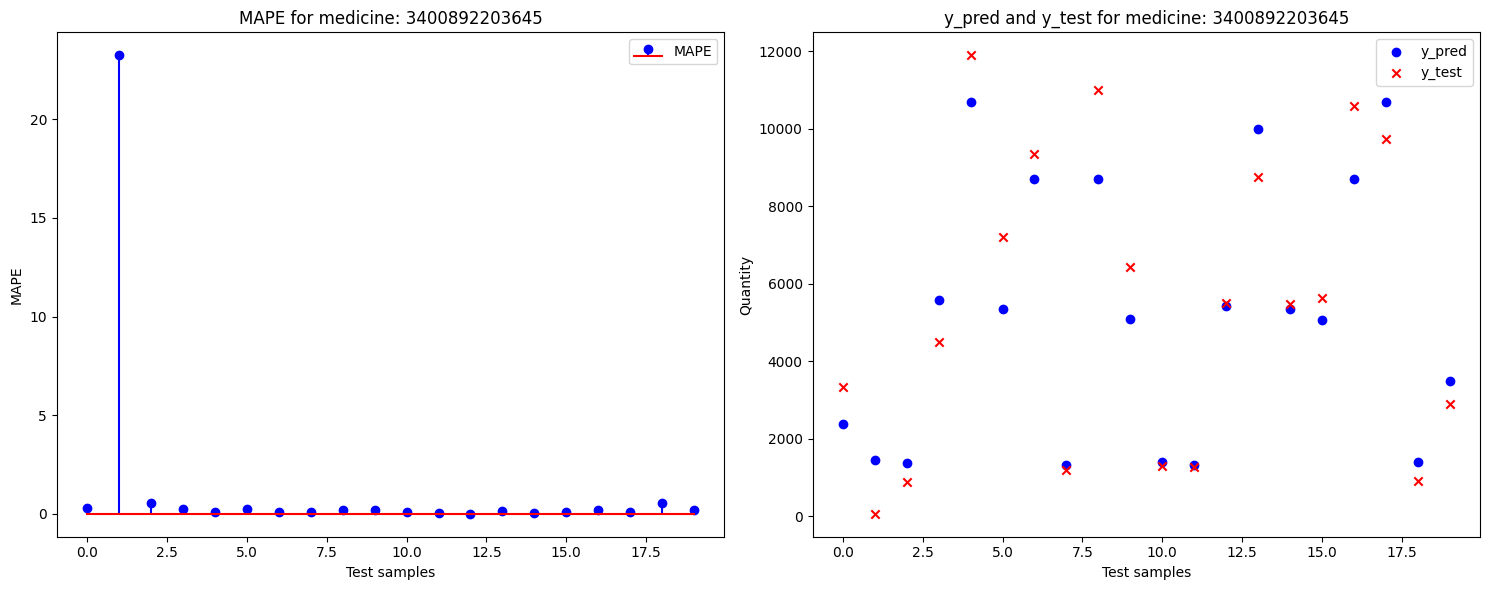



----------------------------------------------------------------------------------------------------
Medicine:3400892065366
Size of data set: 201
Size of training set: 180
Size of test set: 21
Size of grid search: 96
Best Parameters:  {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 7}
Training Score (MAPE):  -1.196
----------Test scores----------
R^2 Score: 0.956
MAE: 701.257
MAPE: 0.558
RMSE: 917.418




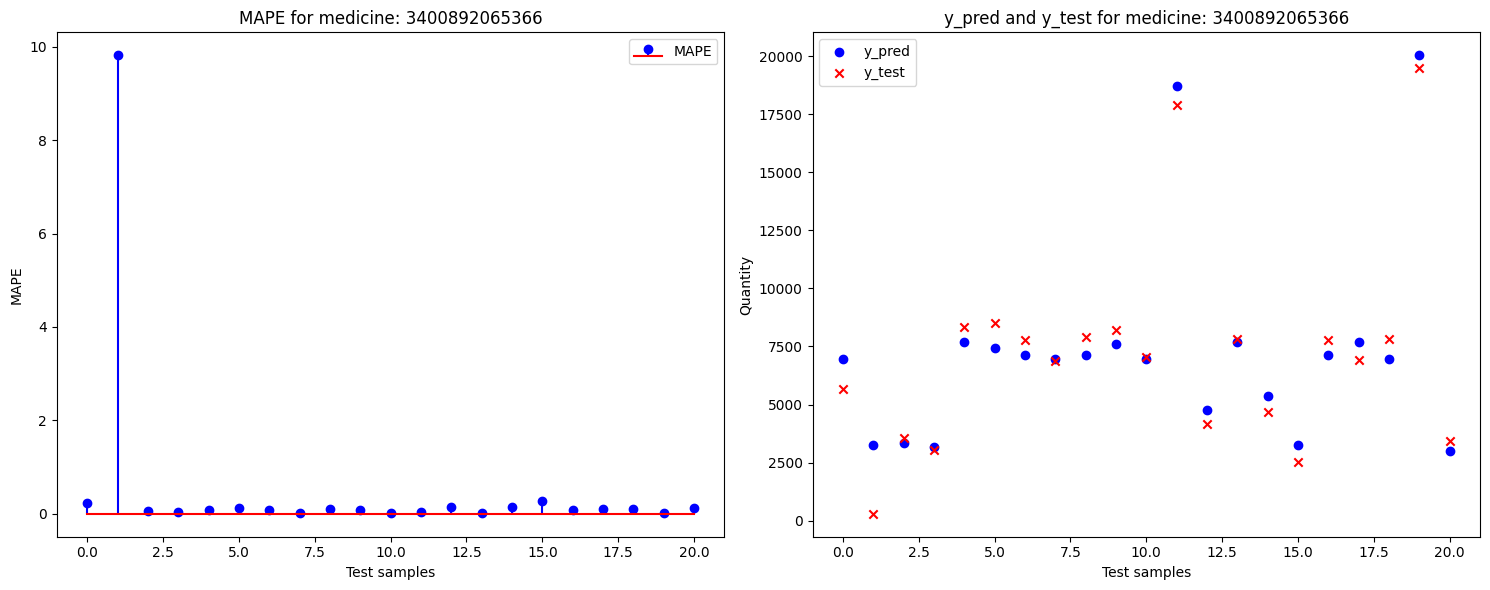



----------------------------------------------------------------------------------------------------
Medicine:3400892052120
Size of data set: 195
Size of training set: 175
Size of test set: 20
Size of grid search: 96
Best Parameters:  {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 7}
Training Score (MAPE):  -1.441
----------Test scores----------
R^2 Score: 0.959
MAE: 429.777
MAPE: 3.192
RMSE: 654.059




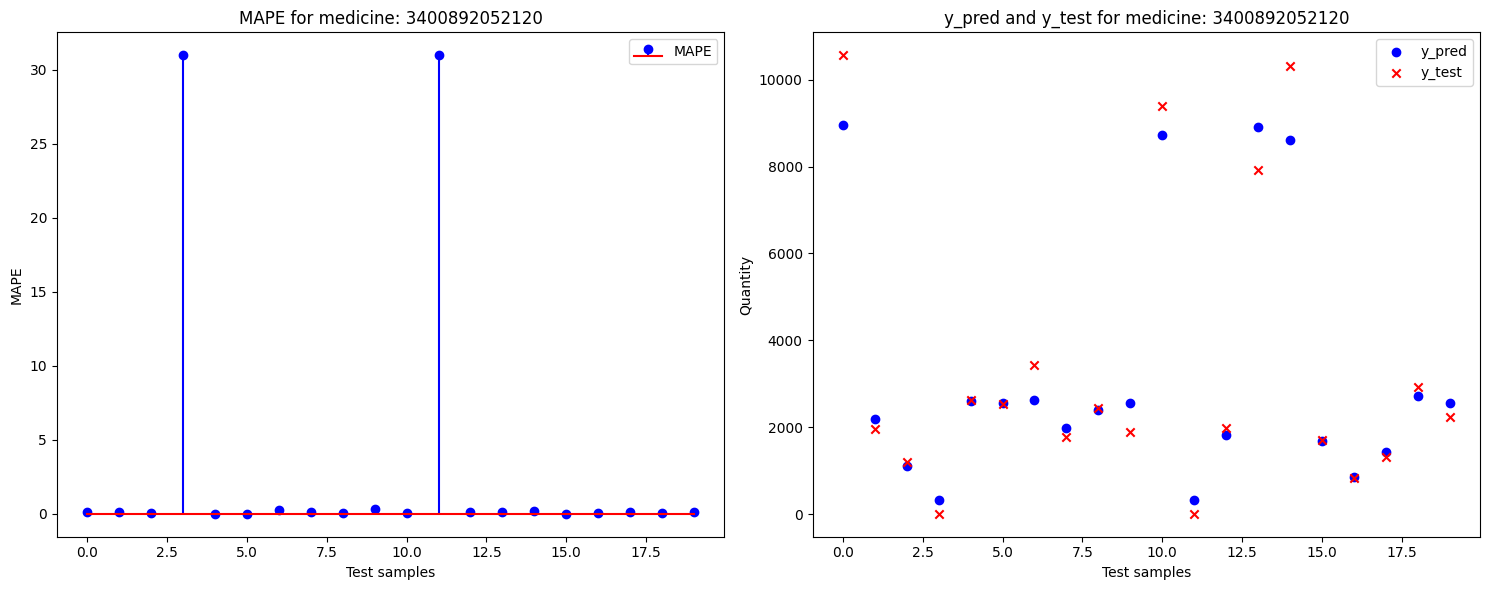



----------------------------------------------------------------------------------------------------
Medicine:3400891996128
Size of data set: 205
Size of training set: 184
Size of test set: 21
Size of grid search: 102
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 6}
Training Score (MAPE):  -3.798
----------Test scores----------
R^2 Score: 0.958
MAE: 7784.77
MAPE: 35.473
RMSE: 11551.166




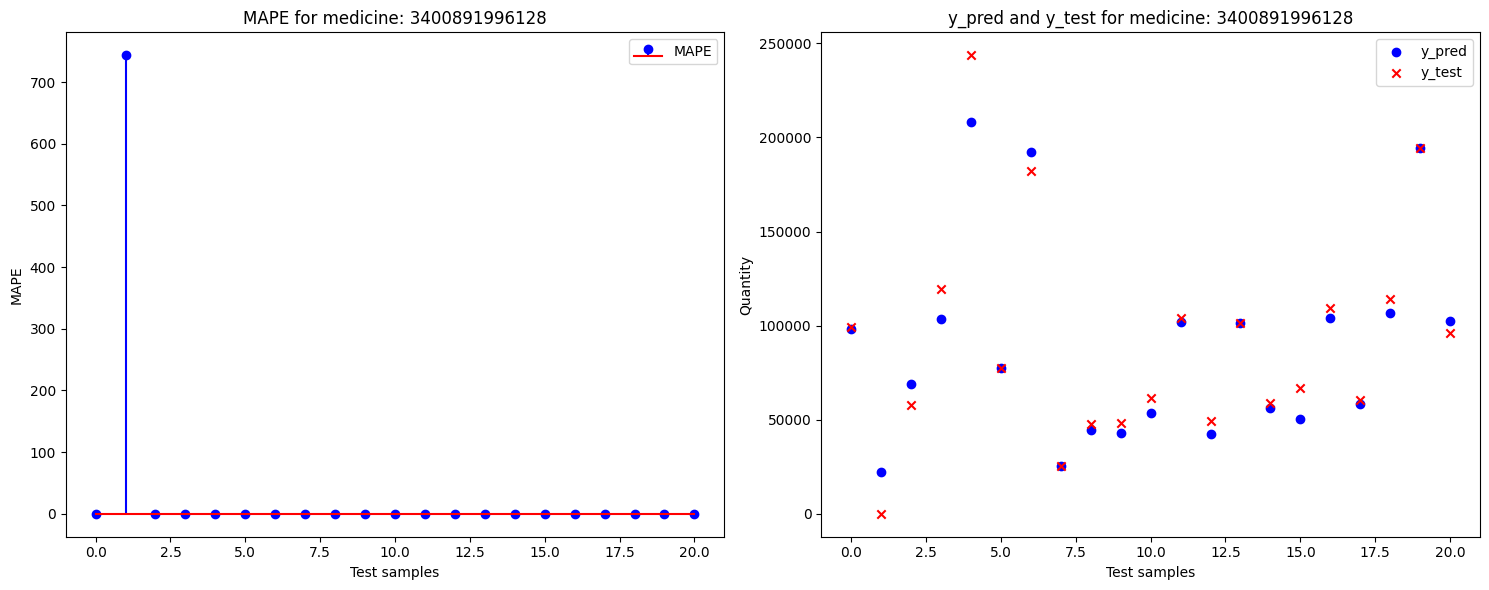



----------------------------------------------------------------------------------------------------
Medicine:3400893826706
Size of data set: 201
Size of training set: 180
Size of test set: 21
Size of grid search: 96
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 2}
Training Score (MAPE):  -13.518
----------Test scores----------
R^2 Score: 0.787
MAE: 893.595
MAPE: 0.648
RMSE: 1255.118




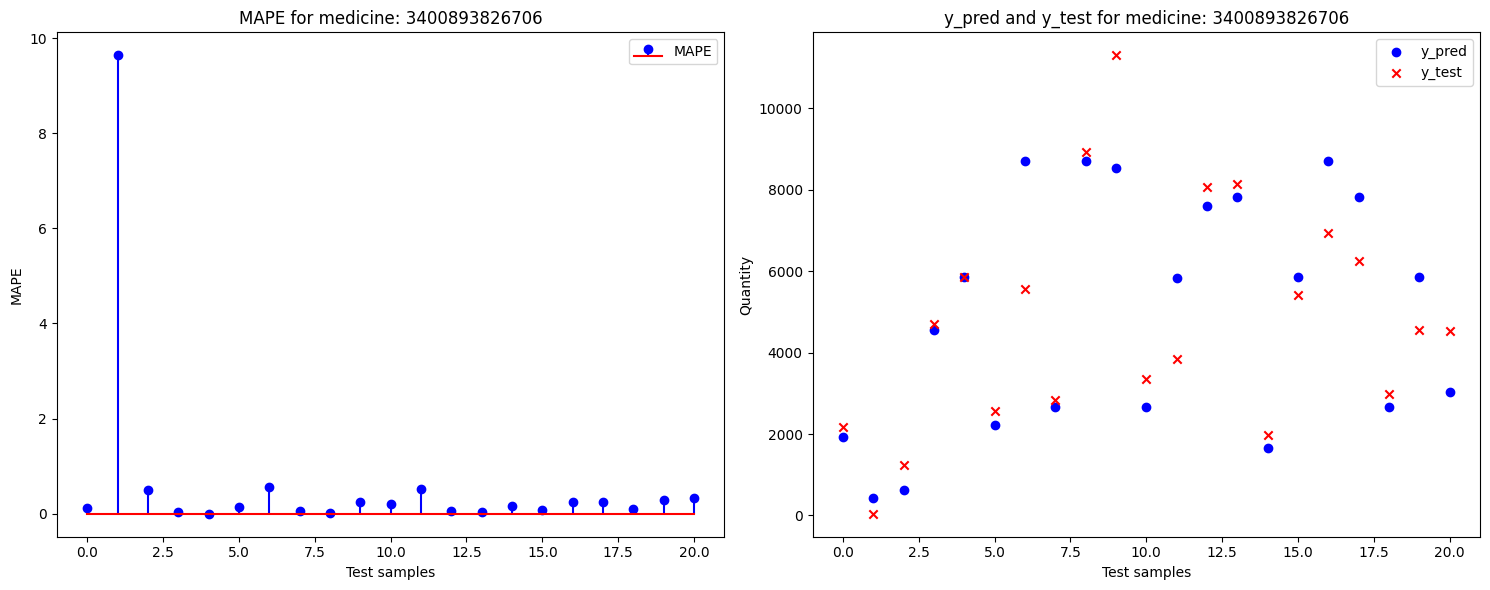



----------------------------------------------------------------------------------------------------
Medicine:3400893736135
Size of data set: 197
Size of training set: 177
Size of test set: 20
Size of grid search: 96
Best Parameters:  {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 13}
Training Score (MAPE):  -0.345
----------Test scores----------
R^2 Score: 0.869
MAE: 509.542
MAPE: 0.113
RMSE: 749.153




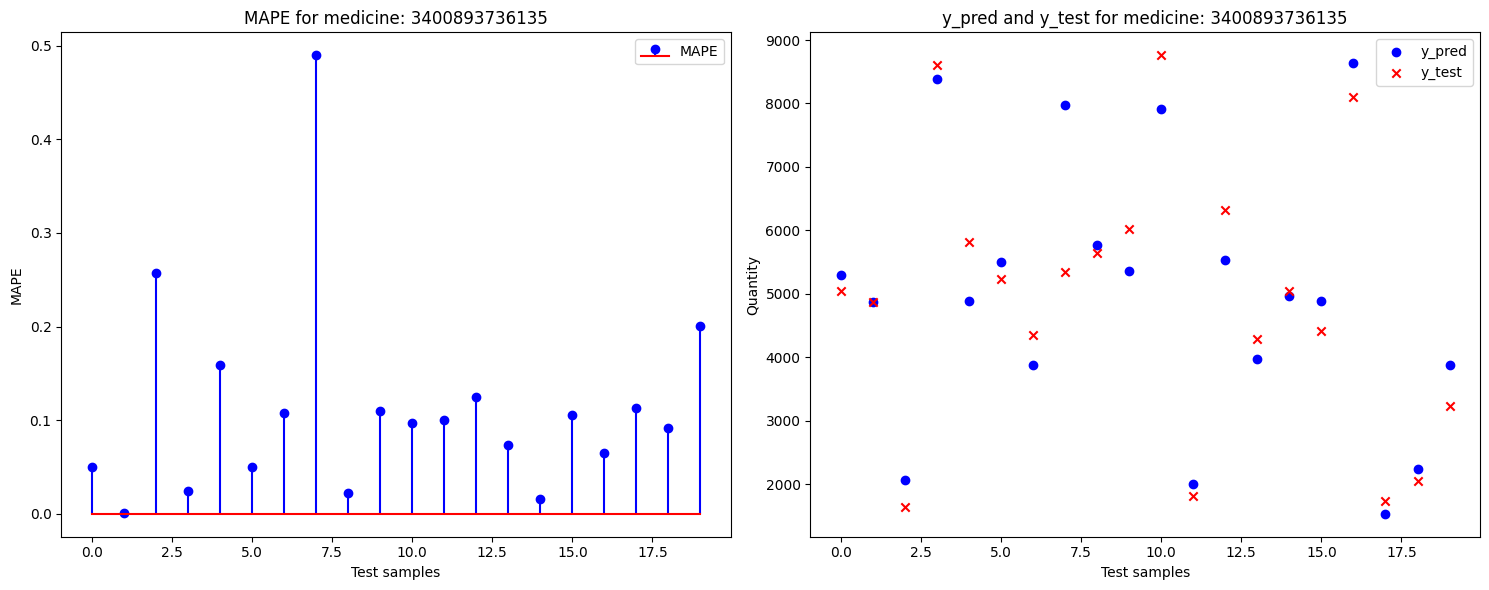



----------------------------------------------------------------------------------------------------
Medicine:3400893875490
Size of data set: 201
Size of training set: 180
Size of test set: 21
Size of grid search: 96
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 2}
Training Score (MAPE):  -3.389
----------Test scores----------
R^2 Score: 0.867
MAE: 1455.332
MAPE: 0.402
RMSE: 2102.807




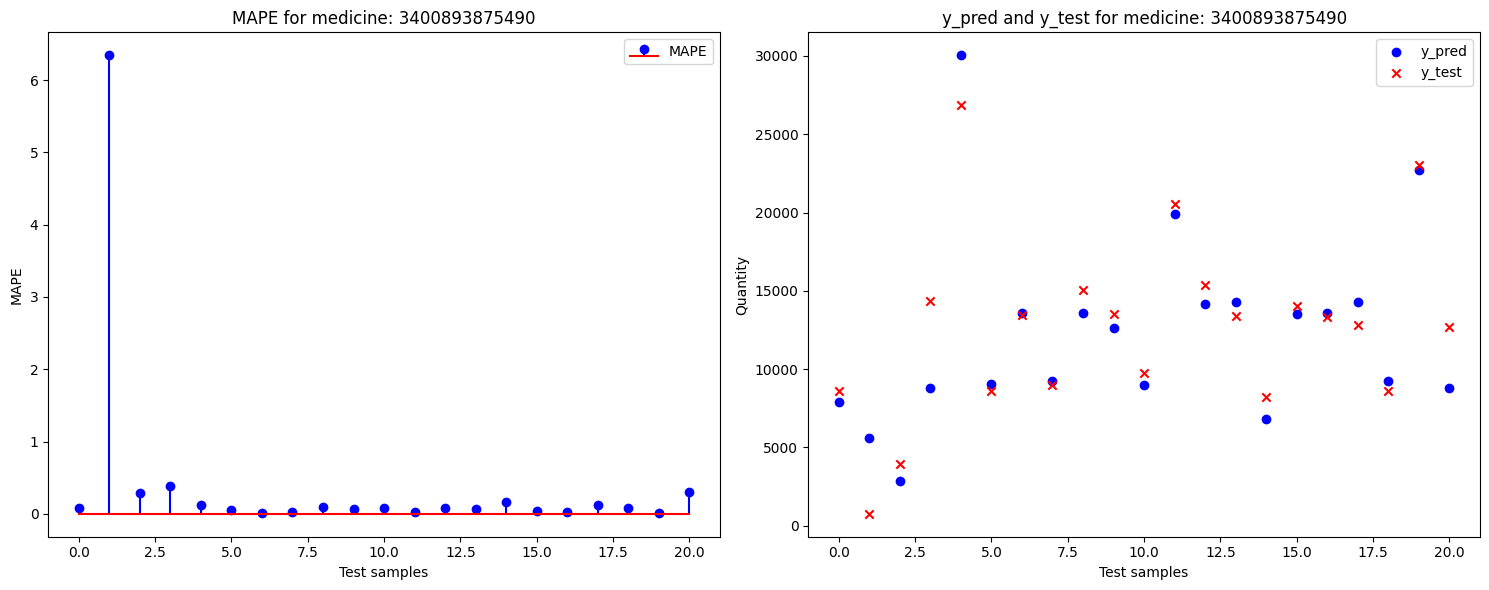



----------------------------------------------------------------------------------------------------
Medicine:3400890837149
Size of data set: 207
Size of training set: 186
Size of test set: 21
Size of grid search: 102
Best Parameters:  {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 17}
Training Score (MAPE):  -2.119
----------Test scores----------
R^2 Score: 0.755
MAE: 1828.363
MAPE: 6.619
RMSE: 3060.312




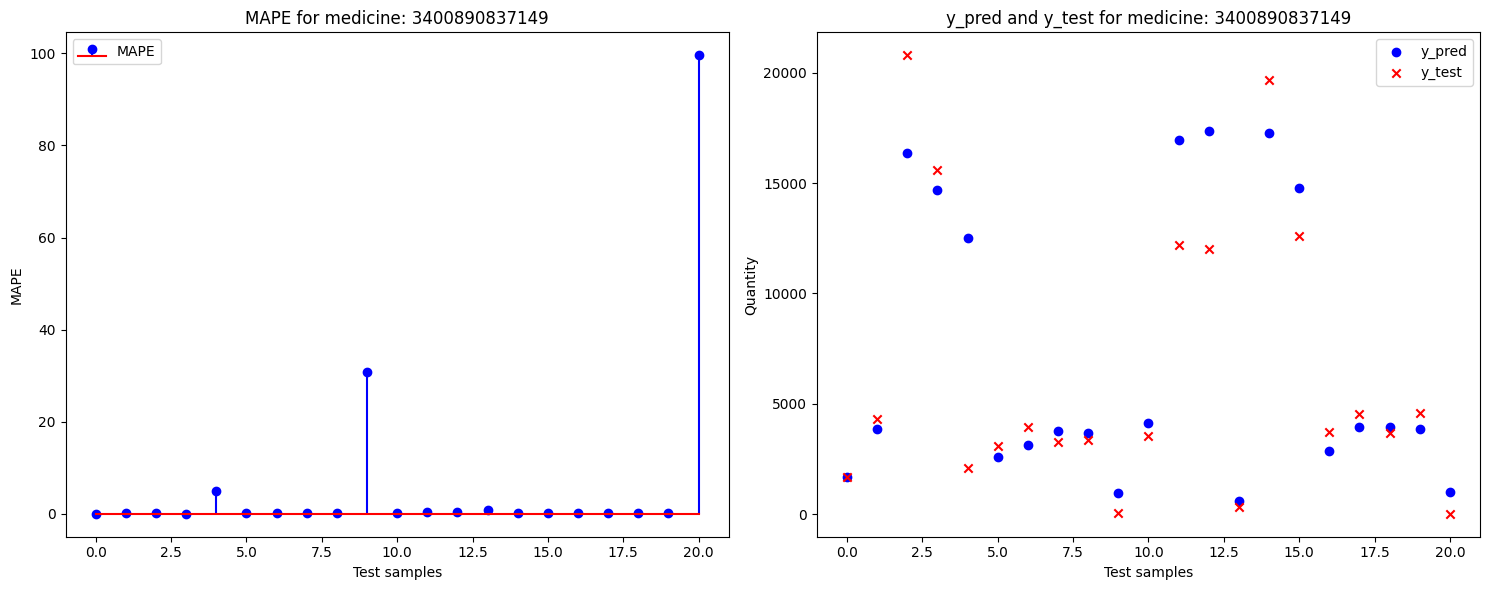



----------------------------------------------------------------------------------------------------
Medicine:3400891235203
Size of data set: 188
Size of training set: 169
Size of test set: 19
Size of grid search: 90


In [ ]:
df_prediction_scores = pd.DataFrame(columns=['HOSPI_CODE_UCD', 'R2', 'RMSE', 'MAE', 'MAPE'])

for medicine in medicines:
  df_prediction_scores = test_1_baseline(df, medicine, df_prediction_scores)

df_prediction_scores

In [ ]:
def train_test_split_modified(df, random_state = 42, test_size = 0.1, Shuffle = False):
  df_iter = df.copy()

  np.random.seed(random_state)

  X_train = []
  y_train = []

  X_test = []
  y_test = []

  columns = df.columns

  df_train = pd.DataFrame(columns=columns)
  df_test = pd.DataFrame(columns=columns)
  i = 0
  for medicine in df_iter.HOSPI_CODE_UCD.unique():
    df_temp = df_iter[df_iter['HOSPI_CODE_UCD'] == medicine]
    i += len(df_temp)
    n_samples = len(df_temp)


    if n_samples == 1:
      print('Not enough samples in cluster')
      test_samples = 1
    else:
      test_samples = max(m.ceil(n_samples * test_size), 2)


    for _ in range(test_samples):
      random_index = np.random.choice(df_temp.index)
      random_row = df_temp.loc[random_index].to_frame().T

      # Concatenate the new row to the original DataFrame
      df_test = pd.concat([df_test, random_row], ignore_index=False)

      # Remove the selected index from df_temp
      df_temp = df_temp.drop(random_index)

    df_iter = df_iter.drop(df_iter[df_iter['HOSPI_CODE_UCD'] == medicine].index)

  # Get the indices of rows to exclude from df
  exclude_indices = df_test.index

  # Create df_train by dropping the rows specified by the exclude_indices from df
  df_train = df.drop(exclude_indices)

  if shuffle:
    X_train, y_train = shuffle(df_train.drop(['QUANTITY', 'CLUSTER'], axis=1), df_train.QUANTITY.values, random_state = random_state)
    X_test, y_test = shuffle(df_test.drop(['QUANTITY', 'CLUSTER'], axis=1).values, df_test.QUANTITY.values, random_state = random_state)

  return X_train, X_test, y_train, y_test

In [ ]:
def test_2_clustering(df, df_scores, medicines):
  for cluster in df.CLUSTER.unique():
    print()
    print(100*'-')
    print(f'Cluster: {cluster}')

    # Perform the train-test split with shuffled samples
    X_train, X_test, y_train, y_test = train_test_split_modified(df[df['CLUSTER'] == cluster].drop(['DATE', 'QUANTITY_MA', 'TREND', 'SEASONAL', 'RESID'], axis=1))
    print(f'Size of data set: {len(X_train) + len(X_test)}')
    print(f'Size of training set: {len(X_train)}')
    print(f'Size of test set: {len(X_test)}')

    df_test = pd.DataFrame(X_test, columns = df.drop(['QUANTITY','CLUSTER','DATE', 'QUANTITY_MA'], axis=1).copy().columns)
    df_test['QUANTITY'] = y_test


    # Define the parameter distributions for RandomizedSearchCV
    param_grid = {
        'max_depth': np.arange(2, 8, 1),
        'n_estimators': np.arange(2, max(int(m.ceil(len(X_train)*0.1)),3), 1),
        'max_features': ['sqrt']
    }

    depth_len = param_grid['max_depth'].size
    estimators_len = param_grid['n_estimators'].size

    print(f'Size of grid search: {depth_len * estimators_len}')

    # Create the RandomizedSearchCV object
    grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                              param_grid=param_grid,
                              scoring = 'neg_mean_absolute_percentage_error',
                              cv = 5,
                              n_jobs = -1)

    ''' >3 : the fold and candidate parameter indexes
        are also displayed together with the starting time of the computation.
    '''

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Fit the RandomizedSearchCV object to the data
    grid_search.fit(X_train_scaled, y_train)
    print("Finished training")

    # Get the best estimator
    best_estimator = grid_search.best_estimator_

    for medicine in df_test.HOSPI_CODE_UCD.unique():
      print()
      print(100*'-')
      print('Medicine:' + str(medicine))

      X_test_medicine = df_test[df_test['HOSPI_CODE_UCD'] == medicine].drop(['QUANTITY'], axis=1).copy().values

      scaler = StandardScaler()
      X_test_scaled = scaler.fit_transform(X_test_medicine)

      y_test_medicine = df_test[df_test['HOSPI_CODE_UCD'] == medicine]['QUANTITY'].copy().values

      # Make predictions using the best estimator
      y_pred = best_estimator.predict(X_test_scaled)

      # Calculate R^2 score
      r2 = r2_score(y_test_medicine, y_pred)

      # Calculate MAE
      mae = mean_absolute_error(y_test_medicine, y_pred)

      # Calculate MAPE
      mape = mean_absolute_percentage_error(y_test_medicine, y_pred)

      # Calculate RMSE
      rmse = np.sqrt(mean_squared_error(y_test_medicine, y_pred))

      # Print the best parameters, best score, and evaluation metrics

      # Print the best parameters, best score, and evaluation metrics
      print('Best Parameters: ', grid_search.best_params_)
      print('Training Score (MAPE): ', round(grid_search.best_score_, 3))
      print(10*'-' + 'Test scores' + 10*'-')
      print('R^2 Score:', round(r2, 3))
      print('MAE:', round(mae, 3))
      print('MAPE:', round(mape, 3))
      print('RMSE:', round(rmse, 3))
      print()


      # Create the new row as a DataFrame
      new_row = pd.DataFrame({'CLUSTER': [cluster],
                              'HOSPI_CODE_UCD': ['CODE_UCD_'+str(int(medicine))],
                              'R2': [r2],
                              'RMSE': [rmse],
                              'MAE': [mae],
                              'MAPE': [mape]})

      # Append the new row to the DataFrame
      df_scores = pd.concat([df_scores, new_row], ignore_index=True)

      plot_mape(y_pred, y_test_medicine, medicine)
      print()

      plot_pred(y_pred, y_test_medicine, medicine)
      print()


  # Return the updated DataFrame
  return df_scores

In [ ]:
df_prediction_scores_agg = pd.DataFrame(columns=[ 'HOSPI_CODE_UCD', 'CLUSTER', 'R2', 'RMSE', 'MAE', 'MAPE'])

df_prediction_scores_agg = test_2_clustering(df_agg_clusters, df_prediction_scores_agg, medicines)

df_prediction_scores_agg

In [ ]:
df_prediction_scores_pca = pd.DataFrame(columns=[ 'HOSPI_CODE_UCD', 'CLUSTER', 'R2', 'RMSE', 'MAE', 'MAPE'])

df_prediction_scores_pca = test_2_clustering(df_clustered_pca, df_prediction_scores_pca, medicines)

df_prediction_scores_pca